In [29]:
# To mount drive
# To be used only in google Colab. 
from google.colab import drive
drive.mount('/content/drive')

# If not, comment out this cell and provide the path in pd.read_csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Importing Libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional,LSTM,Dense,Flatten,Conv1D,MaxPooling1D,Dropout,RepeatVector
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.metrics import Mean

In [31]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/mars-weather.csv')

In [32]:
# Information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1894 non-null   int64  
 1   terrestrial_date  1894 non-null   object 
 2   sol               1894 non-null   int64  
 3   ls                1894 non-null   int64  
 4   month             1894 non-null   object 
 5   min_temp          1867 non-null   float64
 6   max_temp          1867 non-null   float64
 7   pressure          1867 non-null   float64
 8   wind_speed        0 non-null      float64
 9   atmo_opacity      1894 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 148.1+ KB


In [33]:
# Peak into the dataset
df.head(5)

,id,terrestrial_date,sol,ls,month,min_temp,max_temp,pressure,wind_speed,atmo_opacity
0,1895,2018-02-27,1977,135,Month 5,-77.0,-10.0,727.0,NaN,Sunny
1,1893,2018-02-26,1976,135,Month 5,-77.0,-10.0,728.0,NaN,Sunny
2,1894,2018-02-25,1975,134,Month 5,-76.0,-16.0,729.0,NaN,Sunny
3,1892,2018-02-24,1974,134,Month 5,-77.0,-13.0,729.0,NaN,Sunny
4,1889,2018-02-23,1973,133,Month 5,-78.0,-18.0,730.0,NaN,Sunny


In [34]:
# Statistical Description
df.describe()

,id,sol,ls,min_temp,max_temp,pressure,wind_speed
count,1894.000000,1894.000000,1894.000000,1867.000000,1867.000000,1867.000000,0.0
mean,948.372228,1007.930306,169.180570,-76.121050,-12.510445,841.066417,NaN
std,547.088173,567.879561,105.738532,5.504098,10.699454,54.253226,NaN
min,1.000000,1.000000,0.000000,-90.000000,-35.000000,727.000000,NaN
25%,475.250000,532.250000,78.000000,-80.000000,-23.000000,800.000000,NaN
50%,948.500000,1016.500000,160.000000,-76.000000,-11.000000,853.000000,NaN
75%,1421.750000,1501.750000,259.000000,-72.000000,-3.000000,883.000000,NaN
max,1895.000000,1977.000000,359.000000,-62.000000,11.000000,925.000000,NaN


In [35]:
# Drop as it contains null values
df.drop(['id','wind_speed'], axis=1, inplace=True)

In [36]:
# Converting the column `terrestrial_date` into datetime
df['terrestrial_date']=pd.to_datetime(df['terrestrial_date'])

In [39]:
def plot(df, col_index, x_label, y_label):
    plt.figure(figsize=(24,12))
    df.iloc[:,col_index].value_counts(normalize=True, sort=True).plot(kind='bar')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

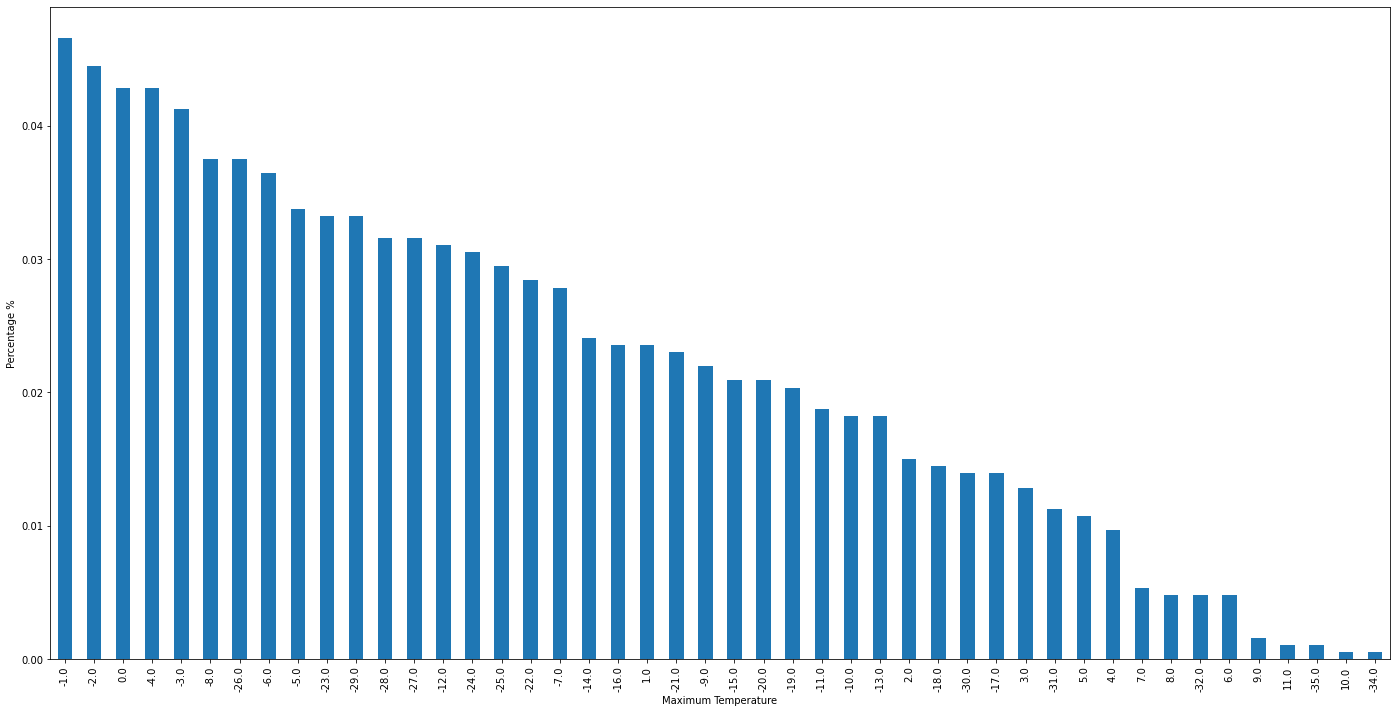

In [41]:
# Visualizing `max_temp`
plot(df,5,'Maximum Temperature','Percentage %')

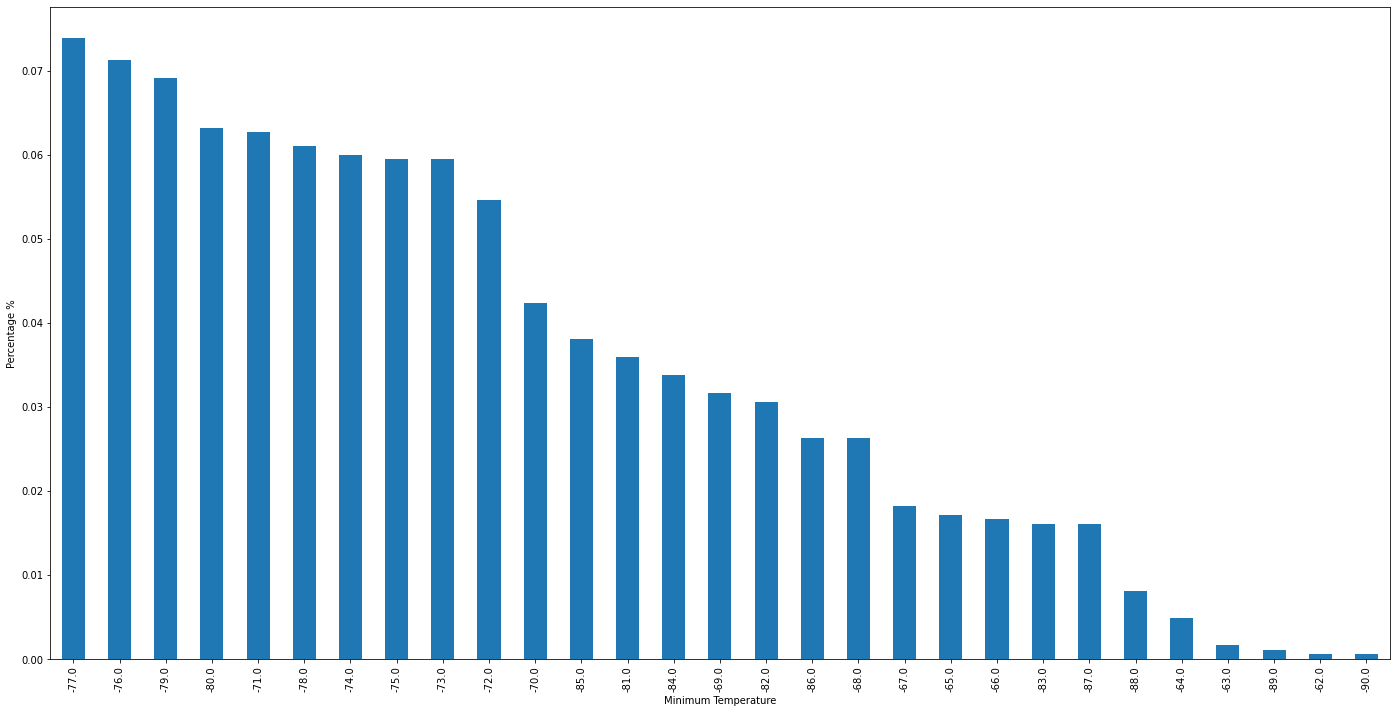

In [42]:
# Visualizing `min_temp`
plot(df,4,'Minimum Temperature','Percentage %')

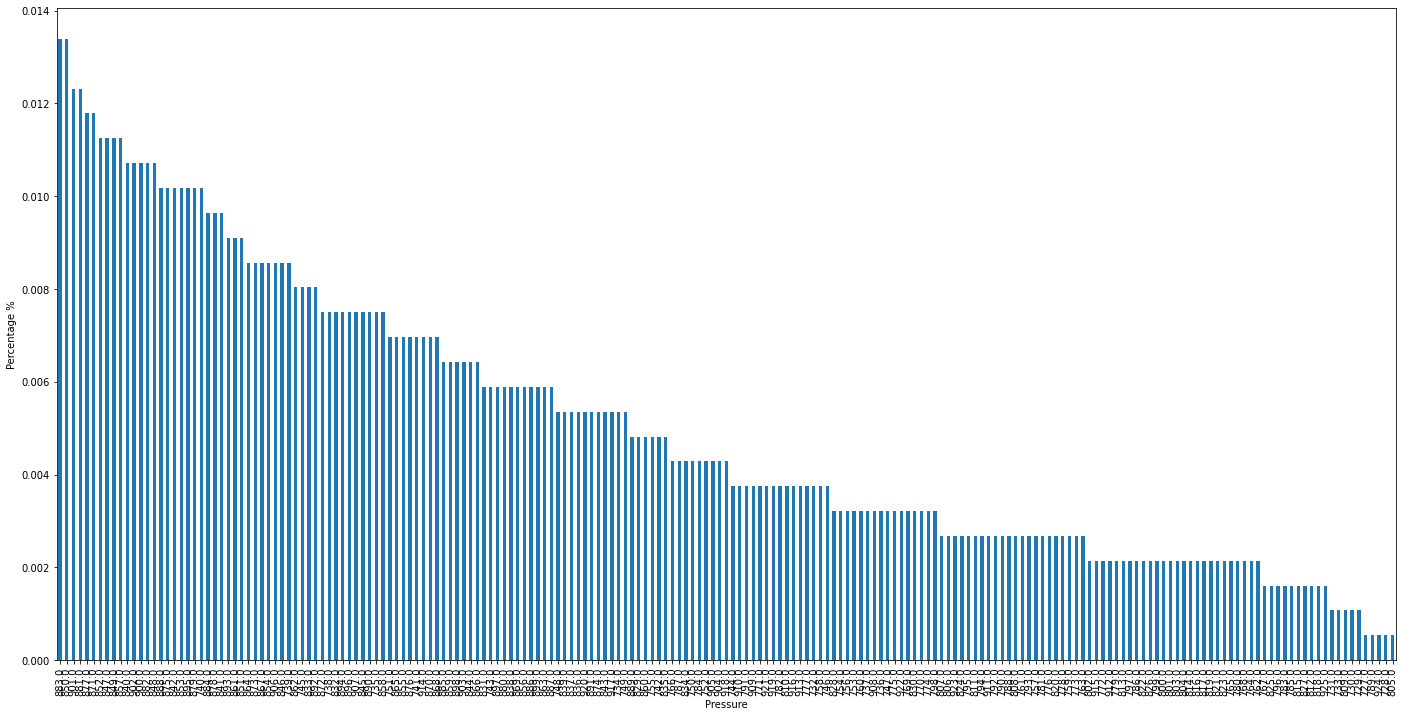

In [43]:
# Visualizing `pressure`
plot(df,6,'Pressure','Percentage %')

In [44]:
# Checking if the target variable contains null values
df.iloc[:,5].isna().sum()

27

In [45]:
df['month']=pd.to_datetime(df.terrestrial_date).dt.to_period('M')
df.month.value_counts()

2017-12    31
2013-01    31
2016-08    31
2014-05    31
2014-10    31
           ..
2015-01    23
2016-07    21
2012-08    18
2013-11    17
2013-03    11
Freq: M, Name: month, Length: 67, dtype: int64

In [46]:
# Treating missing values in the target column
monthly_mean = df.groupby(by='month')['max_temp'].mean()
is_val_nan = df['max_temp'].isna()
# impute values
df.loc[is_val_nan, ['max_temp']]=df.loc[is_val_nan, 'month'].apply(lambda x:monthly_mean[x])
df['max_temp'].isnull().sum()

0

In [47]:
# Isolating the dataframe for target and time
df2 = df[['terrestrial_date', 'max_temp']].set_index('terrestrial_date')

In [48]:

# Creating resampled datasets over different time periods
df2_day = df2.resample('D').mean()
df2_month = df2.resample('M').mean()
df2_year = df2.resample('Y').mean()

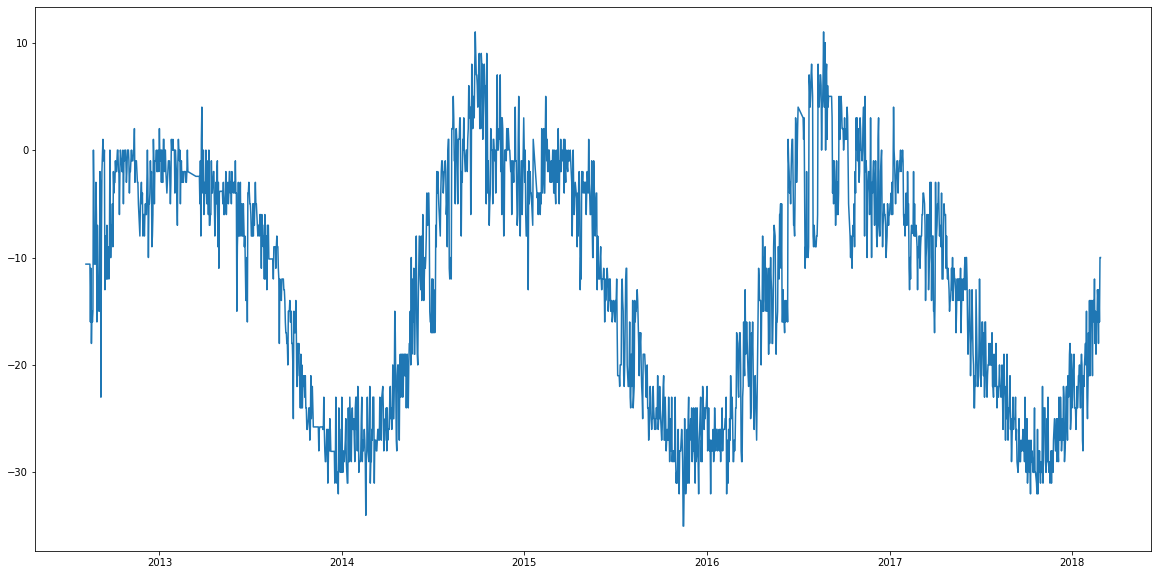

In [49]:
# Visualizing the resampled data's `max_temp` against `terrestrial_date`
plt.figure(figsize=(20,10))
plt.plot(df2)
plt.show()

In [50]:
# Imputing missing values in the resampled data 
data_day2 = df2_day['max_temp'].resample('D').mean().fillna(df['max_temp'].mean())
df2_day2 = pd.DataFrame(data_day2)

In [51]:
df2_day2

,max_temp
terrestrial_date,
2012-08-07,-10.615385
2012-08-08,-12.486749
2012-08-09,-12.486749
2012-08-10,-12.486749
2012-08-11,-12.486749
...,...
2018-02-23,-18.000000
2018-02-24,-13.000000
2018-02-25,-16.000000


In [52]:
# Instantiate the scaler
scaler=MinMaxScaler(feature_range=(-1,1))

In [53]:
# Scale the data
scaled_data=scaler.fit_transform(df2_day2)
scaled_data[:5]


# Shuffle the data
shuffled_data = np.random.permutation(scaled_data)

In [54]:
shuffled_data.shape

(2031, 1)

In [55]:
# Creating timestamps with steps
steps=30
inp=[]
out=[]

for i in range(len(shuffled_data)-steps):
    inp.append(shuffled_data[i:i+steps])
    out.append(shuffled_data[i+steps])

In [56]:
# Split the data
inp = np.asanyarray(inp)
out = np.asanyarray(out)
x_train = inp[:500,:,:]
x_test = inp[500:,:,:]
y_train = out[:500]
y_test = out[500:]

In [57]:
early_stop=EarlyStopping(monitor='loss',patience=5)

# Setting up Activition functions
def percentage_difference(y_true, y_pred):
    return Mean(abs(y_pred/y_true - 1) * 100)
def tanh_activation(x):
    return tf.nn.tanh(x) ** 2

In [58]:
# Modelling LSTM
model=Sequential([Conv1D(100,kernel_size=3,input_shape=(30,1),activation='relu'),
                  Conv1D(100,kernel_size=3),
                  Conv1D(100,kernel_size=3),
                  MaxPooling1D(2),
                 Flatten(),
                  RepeatVector(30),
                 LSTM(128,activation='relu',return_sequences=True),
                 LSTM(64,activation='relu',return_sequences=True),
                  Bidirectional(LSTM(64,activation='relu')),
                 Dense(128,activation='relu'),
                 Dense(1)])

model.compile(optimizer='Adam',loss='mse')

In [59]:
# Fit the model
model.fit(x_train,y_train,epochs=50)

Epoch 1/50
16/16 [==============================] - 7s 211ms/step - loss: 0.2096
Epoch 2/50
16/16 [==============================] - 5s 321ms/step - loss: 0.2109
Epoch 3/50
16/16 [==============================] - 3s 206ms/step - loss: 0.2093
Epoch 4/50
16/16 [==============================] - 4s 222ms/step - loss: 0.2047
Epoch 5/50
16/16 [==============================] - 3s 208ms/step - loss: 0.1952
Epoch 6/50
16/16 [==============================] - 3s 206ms/step - loss: 0.1877
Epoch 7/50
16/16 [==============================] - 3s 208ms/step - loss: 0.1664
Epoch 8/50
16/16 [==============================] - 3s 212ms/step - loss: 2.7475
Epoch 9/50
16/16 [==============================] - 3s 213ms/step - loss: 0.2086
Epoch 10/50
16/16 [==============================] - 3s 214ms/step - loss: 0.2207
Epoch 11/50
16/16 [==============================] - 3s 213ms/step - loss: 0.2473
Epoch 12/50
16/16 [==============================] - 3s 210ms/step - loss: 0.2128
Epoch 13/50
16/16 [======

In [60]:
# Make Predictions
predictions = model.predict(x_test)
predicted = scaler.inverse_transform(predictions)
y_test_pred=scaler.inverse_transform(y_test)

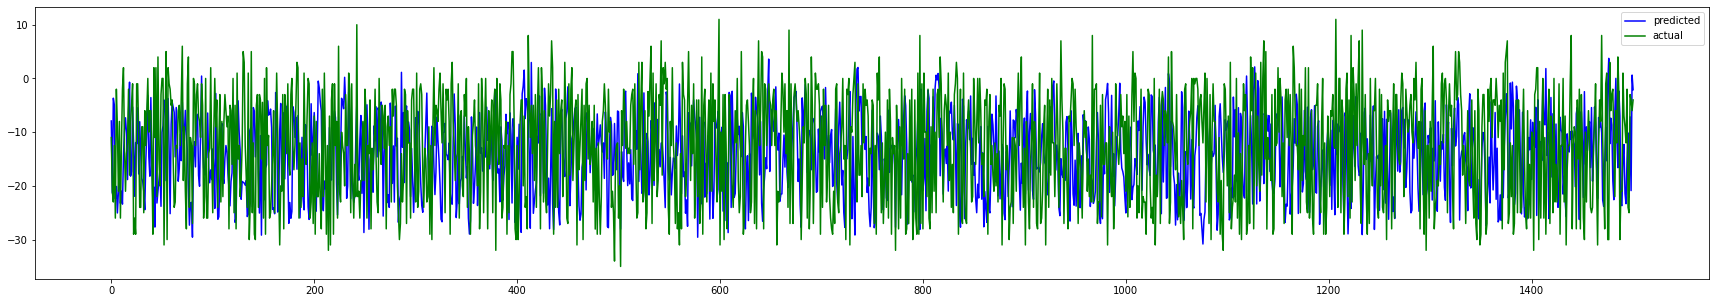

In [61]:
# Visualize the Predictions
plt.figure(figsize=(30,5))
plt.plot(predicted,'b',label='predicted')
plt.plot(y_test_pred,'g',label='actual')
plt.legend()
plt.show()